# **Topic Modeling with Quantized LLMs**
*Create easily interpretable topics with BERTopic and LLMs*
<br>

<img src="https://pbs.twimg.com/media/GDA2JQoX0AElWoq?format=jpg&name=large">


---
        
💡 **NOTE**: We will want to use a GPU to run both 7B LLMs as well as BERTopic for this use case. In Google Colab, go to
**Runtime > Change runtime type > Hardware accelerator > GPU > GPU type > T4**.

---

We will start by installing a number of packages that we are going to use throughout this example:

In [1]:
"""
#%%capture
# BERTopic + llama-cpp-python
!CMAKE_ARGS="-DLLAMA_CUBLAS=on" FORCE_CMAKE=1 pip install llama-cpp-python --force-reinstall --no-cache-dir
!pip install bertopic datasets

# DataMapPlot
#!git clone https://github.com/TutteInstitute/datamapplot.git
#!pip install datamapplot/.
!pip install datamapplot
"""

'\n#%%capture\n# BERTopic + llama-cpp-python\n!CMAKE_ARGS="-DLLAMA_CUBLAS=on" FORCE_CMAKE=1 pip install llama-cpp-python --force-reinstall --no-cache-dir\n!pip install bertopic datasets\n\n# DataMapPlot\n#!git clone https://github.com/TutteInstitute/datamapplot.git\n#!pip install datamapplot/.\n!pip install datamapplot\n'

In [2]:
"""
# GPU-accelerated HDBSCAN + UMAP
!pip install cudf-cu12 dask-cudf-cu12 --extra-index-url=https://pypi.nvidia.com
!pip install cuml-cu12 --extra-index-url=https://pypi.nvidia.com
!pip install cugraph-cu12 --extra-index-url=https://pypi.nvidia.com
!pip install cupy-cuda12x -f https://pip.cupy.dev/aarch64
"""

'\n# GPU-accelerated HDBSCAN + UMAP\n!pip install cudf-cu12 dask-cudf-cu12 --extra-index-url=https://pypi.nvidia.com\n!pip install cuml-cu12 --extra-index-url=https://pypi.nvidia.com\n!pip install cugraph-cu12 --extra-index-url=https://pypi.nvidia.com\n!pip install cupy-cuda12x -f https://pip.cupy.dev/aarch64\n'

In [3]:
from datasets import load_dataset
import pandas as pd
from llama_cpp import Llama
from bertopic.representation import KeyBERTInspired, LlamaCPP


# 📄 **Data**

We are going to apply topic modeling on a number of ArXiv abstracts. They are a great source for topic modeling since they contain a wide variety of topics and are generally well-written.

In [4]:

# ArXiv ML Documents
#docs = load_dataset("CShorten/ML-ArXiv-Papers")["train"]["abstract"]

csv_path = 'data/Trustpilot/www.darty.com.xlsx'
feedbacks_df = pd.read_excel(csv_path)
feedbacks_df['Date'] = pd.to_datetime(feedbacks_df['Date'], format='%B %d, %Y', errors='coerce')
feedbacks_df['Content'] = feedbacks_df['Content'].fillna('')
docs = list(feedbacks_df['Title'] + " : " + feedbacks_df['Content'])

In [181]:
text = """
Experience en magasin:
    Accueil et conseil:
        Personnel aimable et accueillant
        Personnel compétent et à l'écoute
        Personnel peu aimable ou incompétent
    Disponibilité des produits:
        Produits disponibles en magasin
        Produits indisponibles en magasin
    Processus d'achat:
        Processus d'achat facile et rapide
        Processus d'achat compliqué ou long
    Darty Max:
        Adhésion et avantages Darty Max
        Problèmes avec l'adhésion Darty Max
    Autres services en magasin:
        Livraison et installation
        Retrait en magasin
        Services après-vente en magasin
Expérience en ligne:
    Navigation sur le site:
        Site facile à naviguer
        Site difficile à naviguer
    Processus de commande:
        Processus de commande facile et rapide
        Processus de commande compliqué ou long
    Livraison:
        Livraison rapide et fiable
        Livraison lente ou problématique
    Retours et remboursements:
        Retours et remboursements faciles
        Retours et remboursements difficiles
    Service client en ligne:
        Service client en ligne efficace
        Service client en ligne inefficace
Qualité des produits:
    Produits de qualité:
        Produits fiables et durables
        Produits performants
    Produits défectueux ou de mauvaise qualité:
        Produits défectueux à la livraison
        Produits qui tombent en panne rapidement
    Produits ne répondant pas aux attentes:
        Produits ne correspondant pas à la description
        Produits ne répondant pas aux besoins du client
Service après-vente:
    Réparation et échange:
        Réparation et échange faciles et rapides
        Réparation et échange difficiles ou longs
    Garantie et assurance:
        Garantie et assurance utiles
        Garantie et assurance inutiles ou difficiles à utiliser
    Service après-vente général:
        Service après-vente efficace et professionnel
        Service après-vente inefficace et peu professionnel
Prix et promotions:
    Prix:
        Prix compétitifs
        Prix élevés
    Promotions:
        Promotions intéressantes
        Promotions peu intéressantes
    Remboursements et gestes commerciaux:
        Remboursements et gestes commerciaux satisfaisants
        Remboursements et gestes commerciaux insatisfaisants
Comparaison avec la concurrence:
    Comparaison des produits:
        Produits Darty supérieurs à la concurrence
        Produits Darty inférieurs à la concurrence
    Comparaison des services:
        Services Darty supérieurs à la concurrence
        Services Darty inférieurs à la concurrence
    Fidélité à Darty:
        Clients fidèles à Darty
        Clients prêts à aller chez la concurrence
"""

In [194]:
import yaml




with open("categs_large.yaml", 'r', encoding='utf-8') as f:
    categs = yaml.safe_load(f)['categories']
categs

[{'Produit': ['Qualité',
   'Prix',
   'Caractéristiques',
   'Fonctionnalités',
   'Marque',
   'Disponibilité']},
 {"Expérience d'achat": ['Facilité de commande',
   'Retrait en magasin',
   'Livraison',
   'Délais de livraison',
   'Respect des délais',
   'Emballage']},
 {'Service client': ['Réactivité',
   'Efficacité',
   'Politesse',
   'Gestion des réclamations',
   'Disponibilité',
   'Remboursement']},
 {'Magasin': ['Accueil',
   'Propreté',
   'Ambiance',
   'Choix en magasin',
   'Disponibilité des produits',
   'Conseils des vendeurs']},
 {'Installation et utilisation': ["Facilité d'installation",
   'Utilisation',
   'Satisfaction',
   'Fiabilité',
   'Durabilité',
   'Entretien']},
 {'SAV et réparation': ['Prise en charge',
   'Délais de réparation',
   'Coût de la réparation',
   'Efficacité de la réparation',
   'Communication du SAV',
   'Disponibilité des pièces détachées']}]

"\ncategories:\n\n    Experience en magasin:\n        Accueil et conseil:\n      \
  \      Personnel aimable et accueillant\n            Personnel compétent et à l'écoute\n\
  \            Personnel peu aimable ou incompétent\n        Disponibilité des produits:\n\
  \            Produits disponibles en magasin\n            Produits indisponibles\
  \ en magasin\n        Processus d'achat:\n            Processus d'achat facile et\
  \ rapide\n            Processus d'achat compliqué ou long\n        Darty Max:\n\
  \            Adhésion et avantages Darty Max\n            Problèmes avec l'adhésion\
  \ Darty Max\n        Autres services en magasin:\n            Livraison et installation\n\
  \            Retrait en magasin\n            Services après-vente en magasin\n \
  \   Expérience en ligne:\n        Navigation sur le site:\n            Site facile\
  \ à naviguer\n            Site difficile à naviguer\n        Processus de commande:\n\
  \            Processus de commande facile

In [159]:
print('\n\n'.join(docs[:200]))

Achat Magic Keyboard avec Touch ID et pave numerique chez Darty : Toujours un très bon service de Darty. La récupération du produit a été rapide en magasin. Le personnel est très accueillant et sympathique.Achat d'un clavier Magic Keyboard avec Touch ID et pave numerique : le clavier est de très bonne qualité. La touche Touch ID permet de s'authentifier rapidement et le pavé numérique est très pratique lorsque l'on programme ou réalise des tâches comptables. L'autonomie de la batterie est très bonne, à 98 % après plusieurs jours d'utilisation. Le clavier est très léger, ce qui est appréciable lors de déplacement. Le seul inconvénient, le prix, comme pour tous les produits Apple.

Très très apprécié d’installer la… : Très très apprécié d’installer la machine et reprendre l’ancienne et installation aussi de l’anti -calcaire et la personne très aimable et l’horaire respecté. Pas de frais de livraison.Je recommande.

Machine à laver Bosch : Commandée sur le site de Darty machine à laver Bo

In [5]:
len(docs)

8979

# 🦙 **Quantized LLM**

In [6]:
#!wget https://huggingface.co/TheBloke/OpenHermes-2.5-Mistral-7B-GGUF/resolve/main/openhermes-2.5-mistral-7b.Q4_K_M.gguf
# !wget https://huggingface.co/TheBloke/dolphin-2.7-mixtral-8x7b-GGUF/resolve/main/dolphin-2.7-mixtral-8x7b.Q3_K_M.gguf

Next, we load the model using `llama-cpp-python`:

We pass the LLM to BERTopic with a custom prompt. Let's add `KeyBERTInspired` representations to compare the LLM representations with:

# 🗨️ **BERTopic**

By pre-calculating the embeddings for each document, we can speed-up additional exploration steps and use the embeddings to quickly iterate over BERTopic's hyperparameters if needed.

🔥 **TIP**: You can find a great overview of good embeddings for clustering on the [MTEB Leaderboard](https://huggingface.co/spaces/mteb/leaderboard).

In [7]:
from sentence_transformers import SentenceTransformer
from cuml.manifold import UMAP
from cuml.cluster import HDBSCAN
import pickle
# from umap import UMAP
# from hdbscan import HDBSCAN


In [8]:

# Pre-calculate embeddings
#embedding_model = SentenceTransformer("BAAI/bge-small-en")
#embedding_model = SentenceTransformer("Salesforce/SFR-Embedding-Mistral")
#embedding_model = SentenceTransformer("intfloat/e5-mistral-7b-instruct")
#embedding_model = SentenceTransformer("intfloat/multilingual-e5-large")
#embedding_model = SentenceTransformer("intfloat/multilingual-e5-large-instruct")
#embedding_model = SentenceTransformer("OrdalieTech/Solon-embeddings-large-0.1")
#embedding_model = SentenceTransformer("hkunlp/instructor-xl")



In [9]:
"""
Models:

"BAAI/bge-small-en"
"Salesforce/SFR-Embedding-Mistral"
"intfloat/e5-mistral-7b-instruct"
"intfloat/multilingual-e5-large"
"intfloat/multilingual-e5-large-instruct"
"OrdalieTech/Solon-embeddings-large-0.1"
"hkunlp/instructor-xl"
"""

'\nModels:\n\n"BAAI/bge-small-en"\n"Salesforce/SFR-Embedding-Mistral"\n"intfloat/e5-mistral-7b-instruct"\n"intfloat/multilingual-e5-large"\n"intfloat/multilingual-e5-large-instruct"\n"OrdalieTech/Solon-embeddings-large-0.1"\n"hkunlp/instructor-xl"\n'

In [10]:

from pathlib import Path
import os

model_name = "OrdalieTech/Solon-embeddings-large-0.1"



my_file = Path("embeddings/"+model_name.split('/')[-1]+".pkl")
if my_file.is_file():

    with open(my_file, 'rb') as f:
        embeddings = pickle.load(f)
    print("Loaded previous embeddings")

else:
    embedding_model = SentenceTransformer(model_name)
    embeddings = embedding_model.encode(docs, prompt="Represent those customer feedbacks for clustering according to their categories, regardless of their emotion. ", show_progress_bar=True, batch_size=32)
    os.makedirs("embeddings", exist_ok=True)
    with open(my_file, 'wb') as f:
        pickle.dump(embeddings, f)
    print("Saved computed embeddings")


embedding_model = SentenceTransformer(model_name)#, device='cpu')


# Pre-reduce embeddings for visualization purposes
reduced_embeddings = UMAP(n_neighbors=15, n_components=2, min_dist=0.0, metric='cosine', random_state=42).fit_transform(embeddings)

README.md:   0%|          | 0.00/19.8k [00:00<?, ?B/s]

Batches:   0%|          | 0/281 [00:00<?, ?it/s]

Saved computed embeddings


To use a quantized LLMs, we make use of the `GGUF` format together with `llama-cpp-python`. When you access any of [TheBloke's quantized models](https://huggingface.co/TheBloke), you can click on files and find specific quantized formats. We are going with a 4-bit quantized model:

In [11]:
# Use llama.cpp to load in a Quantized LLM

#model_path="/home/maitre/Documents/Development/text-generation-webui/models/openhermes-2.5-mistral-7b.Q4_K_M.gguf"
#llm = Llama(model_path=model_path, n_gpu_layers=-1, n_ctx=8096, stop=["Q:", "\n"])

model_path="/home/maitre/Documents/Development/text-generation-webui/models/mixtral-8x7b-instruct-v0.1.Q3_K_M.gguf"
llm = Llama(model_path=model_path, n_gpu_layers=25, n_ctx=8096, stop=["Q:", "\n"])

ggml_init_cublas: GGML_CUDA_FORCE_MMQ:   no
ggml_init_cublas: CUDA_USE_TENSOR_CORES: yes
ggml_init_cublas: found 1 CUDA devices:
  Device 0: NVIDIA GeForce RTX 3090, compute capability 8.6, VMM: yes
llama_model_loader: loaded meta data with 26 key-value pairs and 995 tensors from /home/maitre/Documents/Development/text-generation-webui/models/mixtral-8x7b-instruct-v0.1.Q3_K_M.gguf (version GGUF V3 (latest))
llama_model_loader: Dumping metadata keys/values. Note: KV overrides do not apply in this output.
llama_model_loader: - kv   0:                       general.architecture str              = llama
llama_model_loader: - kv   1:                               general.name str              = mistralai_mixtral-8x7b-instruct-v0.1
llama_model_loader: - kv   2:                       llama.context_length u32              = 32768
llama_model_loader: - kv   3:                     llama.embedding_length u32              = 4096
llama_model_loader: - kv   4:                          llama.block_co

In [165]:

prompt_english_several = """ Q:
I have the following grouping of feedbacks from Darty customers, and want to analyse which topics are concerned by those feedbacks.
[DOCUMENTS]

The topic is described by the following keywords: '[KEYWORDS]'.

Based on the above information, give the categories concerned by those feedbacks. Just answer them separated by a comma, and using only a few words to describe each category.
A:
"""


prompt_english_insight = """ 
I have the following grouping of feedbacks from Darty customers, and want to analyse which topics are concerned by those feedbacks.
[DOCUMENTS]

The topic is described by the following keywords: '[KEYWORDS]'.

What insight that Darty extract from those feedbacks?
The fact that customers appericate or note something is not a very valuable insight.
An insight should help Darty to improve its customer experience and strategy, and be only a few words longs. 
For example, an insight could be: "Difficultt to return products bought on marketplace".
Don't add a preamble such as "insight from one of the feedbacks and that...". 
Answer in a short nominal phrase that is as short and useful as possible. No need to express that the insight comes from customer, as it is obvious. Only give a single insight.

"""
prompt_french_insight = """
Tu disposes du regroupement suivant de retours clients, et souhaite extraire un déduction intéressant de ces retours.
[DOCUMENTS]

Les mots-clés suivants resortent fréquemment dans les commentaires précédents : '[KEYWORDS]'.

Quel déduction l'entreprise peut elle extraire de ces retours ?
La déduction doit aider l'entreprise à améliorer son expérience client ou sa stratégie, et ne contenir que quelques mots.
Par exemple, une déduction pourrait être : « Difficulté à retourner les produits achetés sur la Marketplace ».
Ne donne qu’une seule déduction, et ne mets ni tiret, ni guillement, ni parenthèse.

Formule cette déduction en une phrase éventuellemnt nominale aussi courte et intéressante que possible. 
Déduction:
"""

prompt_english_mono_guided = """ 
I have the following grouping of feedbacks from Darty customers, and want to analyse which topics are concerned by the feedbacks.

Here are the feedbacks from which we want to find the common category:
[DOCUMENTS]

The topic is described by the following keywords: '[KEYWORDS]'.

Based on the above information, give the category, and if possible subcategory, concerned by those feedbacks, among:
'''
Pre-Purchase Experience:
    Website/App:
        Ease of use and navigation
        Product information clarity
        Search functionality
    Product Selection:
        Variety and availability of products
        Competitive pricing
        Difficulty finding specific products
    Promotions and Offers:
        Clarity of promotional terms
        Attractiveness of deals
        Difficulty redeeming promotions

Purchase Process:
    Ordering:
        Online ordering process smoothness
        Difficulty completing orders
        Payment method options and issues
    Delivery:
        Delivery speed and efficiency
        Communication regarding delivery
        Damage or missing items upon delivery

Post-Purchase Experience:
    Customer Service:
        Helpfulness and responsiveness of staff
        Resolution time for inquiries
        Communication channels (phone, email, chat)
    Product:
        Product quality and performance
        Meeting expectations
        Value for money
    Returns and Refunds:
        Ease of return process
        Processing time for refunds
        Communication regarding returns


In-Store Experience:
    Staff helpfulness and knowledge
    Store layout and organization
    Checkout process speed

Overall Satisfaction
'''

Just answer the most precise category possible, and nothing else.
for example, potential responses could be: 
    "Promotions and Offers"
    "Delivery"
    "Value for money"



Give the category that best regroups the feedbacks, and nothing else:
"""
#Give the 10 words that best represent the category of this group of comments.
prompt_english_several_guided = """ 
I have the following grouping of feedbacks from Darty customers, and want to analyse which topics are concerned by the feedbacks.

Here are the feedbacks from which we want to find the common category:
[DOCUMENTS]

The topic is described by the following keywords: '[KEYWORDS]'.

Based on the above information, give the sub-categories that concernes those feedbacks. Here are some example of sub-categories:
'''
Pre-Purchase Experience:
    Website/App:
        Ease of use and navigation
        Product information clarity
        Search functionality
    Product Selection:
        Variety and availability of products
        Competitive pricing
        Difficulty finding specific products
    Promotions and Offers:
        Clarity of promotional terms
        Attractiveness of deals
        Difficulty redeeming promotions

Purchase Process:
    Ordering:
        Online ordering process smoothness
        Difficulty completing orders
        Payment method options and issues
    Delivery:
        Delivery speed and efficiency
        Communication regarding delivery
        Damage or missing items upon delivery

Post-Purchase Experience:
    Customer Service:
        Helpfulness and responsiveness of staff
        Resolution time for inquiries
        Communication channels (phone, email, chat)
    Product:
        Product quality and performance
        Meeting expectations
        Value for money
    Returns and Refunds:
        Ease of return process
        Processing time for refunds
        Communication regarding returns


In-Store Experience:
    Staff helpfulness and knowledge
    Store layout and organization
    Checkout process speed

Overall Satisfaction
'''

for example, potential responses could be: 
    "Promotions and Offers"
    "Ease of return process"
    "Value for money"



Give the categories, and nothing else:
"""
#Give the 10 words that best represent the category of this group of comments.


prompt = """ Q:
J'ai le regroupement de commentaires suivants :
[DOCUMENTS]

Ce regroupement contient les mots-clés suivants : '[KEYWORDS]'.

Sur la base des informations ci-dessus, nomme cette cétegorie de commentaires. N'utilise pas plus de quelques mots.
A:
"""

representation_model = {
    "KeyBERT": KeyBERTInspired(),
    "LLM": LlamaCPP(llm, prompt=prompt_french_insight),
}

In [139]:
# Define sub-models
min_cluster_size=20 #400
umap_model = UMAP(n_neighbors=15, n_components=5, min_dist=0.0, metric='cosine', random_state=42)
hdbscan_model = HDBSCAN(min_cluster_size=min_cluster_size, metric='euclidean', cluster_selection_method='eom', prediction_data=True)

# 🔥 **Training**

Now that we have our models prepared, we can start training our topic model! We supply BERTopic with the sub-models of interest, run `.fit_transform`, and see what kind of topics we get.

In [140]:
import yaml
with open('categs.yaml', 'r') as f:
    categs = yaml.safe_load(f)

print(categs)

{'Pre-Purchase Experience': {'Website/App': ['Ease of use and navigation', 'Product information clarity', 'Search functionality'], 'Product Selection': ['Variety and availability of products', 'Competitive pricing', 'Difficulty finding specific products'], 'Promotions and Offers': ['Clarity of promotional terms', 'Attractiveness of deals', 'Difficulty redeeming promotions']}, 'Purchase Process': {'Ordering': ['Online ordering process smoothness', 'Difficulty completing orders', 'Payment method options and issues'], 'Delivery': ['Delivery speed and efficiency', 'Communication regarding delivery', 'Damage or missing items upon delivery']}, 'Post-Purchase Experience': {'Customer Service': ['Helpfulness and responsiveness of staff', 'Resolution time for inquiries', 'Communication channels (phone, email, chat)'], 'Product': ['Product quality and performance', 'Meeting expectations', 'Value for money'], 'Returns and Refunds': ['Ease of return process', 'Processing time for refunds', 'Communi

In [141]:
categs.items()

dict_items([('Pre-Purchase Experience', {'Website/App': ['Ease of use and navigation', 'Product information clarity', 'Search functionality'], 'Product Selection': ['Variety and availability of products', 'Competitive pricing', 'Difficulty finding specific products'], 'Promotions and Offers': ['Clarity of promotional terms', 'Attractiveness of deals', 'Difficulty redeeming promotions']}), ('Purchase Process', {'Ordering': ['Online ordering process smoothness', 'Difficulty completing orders', 'Payment method options and issues'], 'Delivery': ['Delivery speed and efficiency', 'Communication regarding delivery', 'Damage or missing items upon delivery']}), ('Post-Purchase Experience', {'Customer Service': ['Helpfulness and responsiveness of staff', 'Resolution time for inquiries', 'Communication channels (phone, email, chat)'], 'Product': ['Product quality and performance', 'Meeting expectations', 'Value for money'], 'Returns and Refunds': ['Ease of return process', 'Processing time for re

In [142]:
#subcategs = [k1+" : "+k2+" : "+k3 for (k1, v1) in categs.items() for (k2, v2) in v1.items() for k3 in v2]
zeroshot_topic_list = [k3 for (k1, v1) in categs.items() for (k2, v2) in v1.items() for k3 in v2]
zeroshot_topic_list

['Ease of use and navigation',
 'Product information clarity',
 'Search functionality',
 'Variety and availability of products',
 'Competitive pricing',
 'Difficulty finding specific products',
 'Clarity of promotional terms',
 'Attractiveness of deals',
 'Difficulty redeeming promotions',
 'Online ordering process smoothness',
 'Difficulty completing orders',
 'Payment method options and issues',
 'Delivery speed and efficiency',
 'Communication regarding delivery',
 'Damage or missing items upon delivery',
 'Helpfulness and responsiveness of staff',
 'Resolution time for inquiries',
 'Communication channels (phone, email, chat)',
 'Product quality and performance',
 'Meeting expectations',
 'Value for money',
 'Ease of return process',
 'Processing time for refunds',
 'Communication regarding returns',
 'Staff helpfulness and knowledge',
 'Store layout and organization',
 'Checkout process speed']

In [143]:
seed_topic_list = [(k1+" "+k2+" "+k3).split(" ") for (k1, v1) in categs.items() for (k2, v2) in v1.items() for k3 in v2]
#seed_topic_list = [(k1).split(" ") for (k1, v1) in categs.items() for (k2, v2) in v1.items() for k3 in v2]
#seed_topic_list += [(k2).split(" ") for (k1, v1) in categs.items() for (k2, v2) in v1.items() for k3 in v2]
#seed_topic_list += [(k3).split(" ") for (k1, v1) in categs.items() for (k2, v2) in v1.items() for k3 in v2]
seed_topic_list

[['Pre-Purchase',
  'Experience',
  'Website/App',
  'Ease',
  'of',
  'use',
  'and',
  'navigation'],
 ['Pre-Purchase',
  'Experience',
  'Website/App',
  'Product',
  'information',
  'clarity'],
 ['Pre-Purchase', 'Experience', 'Website/App', 'Search', 'functionality'],
 ['Pre-Purchase',
  'Experience',
  'Product',
  'Selection',
  'Variety',
  'and',
  'availability',
  'of',
  'products'],
 ['Pre-Purchase',
  'Experience',
  'Product',
  'Selection',
  'Competitive',
  'pricing'],
 ['Pre-Purchase',
  'Experience',
  'Product',
  'Selection',
  'Difficulty',
  'finding',
  'specific',
  'products'],
 ['Pre-Purchase',
  'Experience',
  'Promotions',
  'and',
  'Offers',
  'Clarity',
  'of',
  'promotional',
  'terms'],
 ['Pre-Purchase',
  'Experience',
  'Promotions',
  'and',
  'Offers',
  'Attractiveness',
  'of',
  'deals'],
 ['Pre-Purchase',
  'Experience',
  'Promotions',
  'and',
  'Offers',
  'Difficulty',
  'redeeming',
  'promotions'],
 ['Purchase',
  'Process',
  'Orderin

In [144]:
zeroshot_topic_list

['Ease of use and navigation',
 'Product information clarity',
 'Search functionality',
 'Variety and availability of products',
 'Competitive pricing',
 'Difficulty finding specific products',
 'Clarity of promotional terms',
 'Attractiveness of deals',
 'Difficulty redeeming promotions',
 'Online ordering process smoothness',
 'Difficulty completing orders',
 'Payment method options and issues',
 'Delivery speed and efficiency',
 'Communication regarding delivery',
 'Damage or missing items upon delivery',
 'Helpfulness and responsiveness of staff',
 'Resolution time for inquiries',
 'Communication channels (phone, email, chat)',
 'Product quality and performance',
 'Meeting expectations',
 'Value for money',
 'Ease of return process',
 'Processing time for refunds',
 'Communication regarding returns',
 'Staff helpfulness and knowledge',
 'Store layout and organization',
 'Checkout process speed']

In [145]:
from bertopic.representation import ZeroShotClassification

In [146]:
from bertopic import BERTopic

topic_model = BERTopic(

  # Sub-models
  embedding_model=embedding_model,
  umap_model=umap_model,
  hdbscan_model=hdbscan_model,
  representation_model=representation_model,

  # Hyperparameters
  top_n_words=10,
  verbose=True,

  #min_topic_size=20,
  #zeroshot_topic_list=zeroshot_topic_list,
  #zeroshot_min_similarity=.9,
  #seed_topic_list=seed_topic_list,
)

# Train model
topics, probs = topic_model.fit_transform(docs, embeddings)

2024-03-11 18:49:07,086 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2024-03-11 18:49:07,190 - BERTopic - Dimensionality - Completed ✓
2024-03-11 18:49:07,191 - BERTopic - Cluster - Start clustering the reduced embeddings
2024-03-11 18:49:07,347 - BERTopic - Cluster - Completed ✓
2024-03-11 18:49:07,350 - BERTopic - Representation - Extracting topics from clusters using representation models.
  0%|          | 0/19 [00:00<?, ?it/s]Llama.generate: prefix-match hit

llama_print_timings:        load time =    2667.49 ms
llama_print_timings:      sample time =       4.59 ms /    15 runs   (    0.31 ms per token,  3265.84 tokens per second)
llama_print_timings: prompt eval time =   32065.85 ms /  5573 tokens (    5.75 ms per token,   173.80 tokens per second)
llama_print_timings:        eval time =    1104.14 ms /    14 runs   (   78.87 ms per token,    12.68 tokens per second)
llama_print_timings:       total time =   33230.48 ms /  5587 tokens
  5%|▌        

Now that we are done training our model, let's see what topics were generated:

In [147]:
topic_model.get_topic_info()["LLM"][0][0]

'Difficultés à régler les litiges de produits Marketplace'

In [148]:
# Show topics
print("\n".join([x[0] for x in list(topic_model.get_topic_info()["LLM"])]))

Difficultés à régler les litiges de produits Marketplace
Très satisfaits des conseils et du service rapide
Désagréments dans la réparation des machines à laver
La qualité des conseils de vendeurs en magasin est app
Difficultés d'annulation de commande sur la Marketplace
Difficulté à livrer les réfrigérateurs.
"Expéditions tardives de téléphones depuis la Marketplace".
Les consommateurs reprochent des problèmes avec les command
Difficultés liées aux configurations TV
Les clients se plaignent souvent d'abus d'assurance chez
Dysfonctionnement répétitif des fours Darty
Difficultés avec le SAV
Le service client est perçu comme incompétent
"Expérience client d'après-vente médiocre"
Difficultés avec les trottinettes électriques SAV
"Des problèmes récurrents avec les cartouches d'im
Difficulté d'utilisation des cartes cadeaux
La notion de « contrat de confiance » est ternie par les
"Incapacité à gérer les pannes de la part


In [149]:
topic_model.get_topic_info().iloc[0]

Topic                                                                 -1
Count                                                               3257
Name                                                      -1_de_le_et_je
Representation             [de, le, et, je, un, la, darty, pas, que, en]
KeyBERT                [garantie, remboursement, magasin, fois, produ...
LLM                    [Difficultés à régler les litiges de produits ...
Representative_Docs    [La recette miracle pour briser le contrat de ...
Name: 0, dtype: object

# 📊 Visualization with DataMapPlot

In [150]:
import PIL
import numpy as np
import requests


logo = np.asarray(PIL.Image.open("logo_vigie_AI_rb.png"))

We can use the labels created by the LLM and assign them to topics that we have created:

In [151]:
topic_model.get_topics(full=True)["LLM"].values()


dict_values([[('Difficultés à régler les litiges de produits Marketplace', 1), ('', 0), ('', 0), ('', 0), ('', 0), ('', 0), ('', 0), ('', 0), ('', 0), ('', 0)], [('Très satisfaits des conseils et du service rapide', 1), ('', 0), ('', 0), ('', 0), ('', 0), ('', 0), ('', 0), ('', 0), ('', 0), ('', 0)], [('Désagréments dans la réparation des machines à laver', 1), ('', 0), ('', 0), ('', 0), ('', 0), ('', 0), ('', 0), ('', 0), ('', 0), ('', 0)], [('La qualité des conseils de vendeurs en magasin est app', 1), ('', 0), ('', 0), ('', 0), ('', 0), ('', 0), ('', 0), ('', 0), ('', 0), ('', 0)], [("Difficultés d'annulation de commande sur la Marketplace", 1), ('', 0), ('', 0), ('', 0), ('', 0), ('', 0), ('', 0), ('', 0), ('', 0), ('', 0)], [('Difficulté à livrer les réfrigérateurs.', 1), ('', 0), ('', 0), ('', 0), ('', 0), ('', 0), ('', 0), ('', 0), ('', 0), ('', 0)], [('"Expéditions tardives de téléphones depuis la Marketplace".', 1), ('', 0), ('', 0), ('', 0), ('', 0), ('', 0), ('', 0), ('', 0)

In [152]:
import datamapplot
import re

# Create a label for each document
llm_labels = [re.sub(r'\W+', ' ', label[0][0].split("\n")[0].replace('"', '')) for label in topic_model.get_topics(full=True)["LLM"].values()]
llm_labels = [label if label else "Unlabelled" for label in llm_labels]
all_labels = [llm_labels[topic+topic_model._outliers] if topic != -1 else "Unlabelled" for topic in topics]

method = "Zero-shot Topic Modeling"
#method = "Guided Topic Modeling"

llm_name = "Mixtral"


In [153]:
llm_labels

['Difficultés à régler les litiges de produits Marketplace',
 'Très satisfaits des conseils et du service rapide',
 'Désagréments dans la réparation des machines à laver',
 'La qualité des conseils de vendeurs en magasin est app',
 'Difficultés d annulation de commande sur la Marketplace',
 'Difficulté à livrer les réfrigérateurs ',
 'Expéditions tardives de téléphones depuis la Marketplace ',
 'Les consommateurs reprochent des problèmes avec les command',
 'Difficultés liées aux configurations TV',
 'Les clients se plaignent souvent d abus d assurance chez',
 'Dysfonctionnement répétitif des fours Darty',
 'Difficultés avec le SAV',
 'Le service client est perçu comme incompétent',
 'Expérience client d après vente médiocre',
 'Difficultés avec les trottinettes électriques SAV',
 'Des problèmes récurrents avec les cartouches d im',
 'Difficulté d utilisation des cartes cadeaux',
 'La notion de contrat de confiance est ternie par les',
 'Incapacité à gérer les pannes de la part']

In [154]:
llm_labels[4]= 'La qualité du conseil en magasin est décisive et appréciée'



(<Figure size 1600x800 with 1 Axes>,
 <Axes: title={'left': 'OrdalieTech/Solon-embeddings-large-0.1 + Mixtral + Zero-shot Topic Modeling'}>)

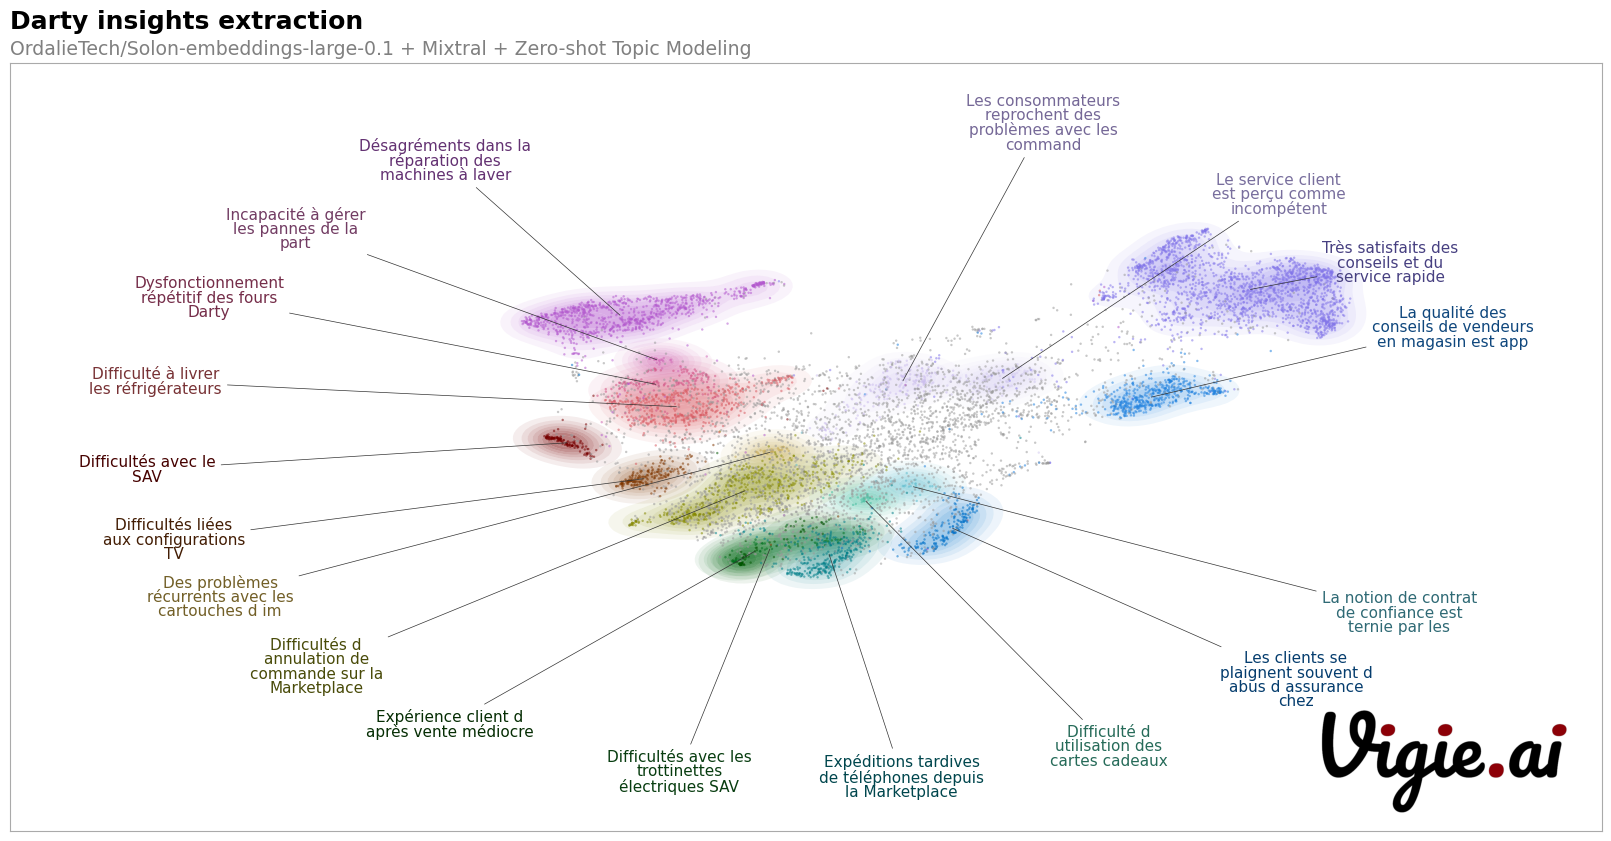

In [155]:

# Run the visualization
datamapplot.create_plot(
    reduced_embeddings,
    all_labels,
    label_font_size=11,
    title="Darty insights extraction", #"Darty feedbacks categorization",
    sub_title=model_name+" + "+llm_name+" + "+method,
    label_wrap_width=20,
    use_medoids=True,
    logo=logo,
    logo_width=0.16,
    figsize=(16, 8)
)